<a href="https://colab.research.google.com/github/Clement-Moreau-Info/CED/blob/main/contextual_edit_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
!pip install scikit-fuzzy

import networkx as nx
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
from numba import prange
from typing import List
import skfuzzy as fuzz
from scipy import signal
import numpy as np
from functools import lru_cache
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import time

     |████████████████████████████████| 1.0MB 8.6MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=61b565abe1379ca3b23f49d3bb06519d45225f6cdadd7acf140ee37b7486ea63
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


# Define ontology and similarity

In [ ]:
# Import the ontology
!wget https://gist.githubusercontent.com/Hector-Plasma/d55b0c617ae8da26dedcf25166aaa35d/raw/68f3eaaf36d6a1725c25dfec5f66da035f990341/ontology_sac.txt -q --show-progress

ontology_sac.txt    100%[===================>]     139  --.-KB/s    in 0s      


In [ ]:
# Path to onntology
path_onto = "ontology_sac.txt"
ontology = nx.read_adjlist(path_onto, create_using=nx.DiGraph)

@lru_cache(maxsize=100000)
def wu_palmer(x: str, y: str, rootnode="All", onto = ontology) -> float:
    return (2.0 * nx.shortest_path_length(onto, rootnode, nx.lowest_common_ancestor(onto, x, y))) / (
            nx.shortest_path_length(onto, rootnode, x) + nx.shortest_path_length(onto, rootnode, y))


# Define the similarity used
def sim(x: str, y: str) -> float:
    return wu_palmer(x, y)

In the defined ontology, the id refer to the following activity symbols: 

1 => 🚲

2 => 🚶‍♂️

3 => 🚗

4 => 🚃

5 => 🥖

6 => 🛍

7 => 📚

8 => 🎬

9 => 💃

10 => ⚽️

11 => 🏊‍♂️


# Contextual Edit Operation

Suppose we want make the edit operation $op$ with new symbol $\mathbf{x}$ at index $i_{edit}$ in the sequence $S_i$. 

Formaly, a contextual edit operation $e$ is a 4-uplet such that:

$$e = (op, \mathbf{x}, i_{edit}, S_i)$$


---
Here we consider sequence $S_1 = \langle$ 🚲, 📚, 🚲, 🏊‍♂️, 🚶‍♂️, 🥖 ,🚶‍♂️, 💃 $\rangle $ and the contextual edit operation $e = (\mathtt{mod},\ $🎬, $4, S_1 \rangle$. 

In [ ]:
from enum import Enum
class Edit(Enum):
  MOD = 1
  ADD = 2
  DEL = 3

class Cxt_edit:
    def __init__(self, op: Edit, x: str, i_edit: int, S_i: List[str]):
        self.op = op
        self.x = x
        self.i_edit = i_edit - 1
        self.S_i = S_i

S1 = ['1', '7', '1', '11', '2', '5', '2', '9']
e = Cxt_edit(Edit.MOD, '8', 4, S1)

We define a fuzzy membership function $\mu$ for the encodinf of the temporal vector $\nu_e$. 

In [ ]:
def temporal_vec(e: Cxt_edit, beta : int) -> List[float]:
    mu = fuzz.trapmf(np.arange(0, np.sum(len(e.S_i)+1)),
                     [e.i_edit - beta, e.i_edit, e.i_edit, e.i_edit + beta])
    if e.op == Edit.MOD:
        return mu[:-1]
    if e.op == Edit.ADD:
        return [mu[i] if i < e.i_edit else
                (mu[e.i_edit - 1] if i == e.i_edit else mu[i + 1])
                for i in range(len(e.S_i))]
    else:
        return [mu[i] if i != e.i_edit else 0 for i in range(len(e.S_i))]

nu = temporal_vec(e, 4)
print(nu)
#plt.figure(figsize=(10, 8))
#plt.plot(np.arange(0, np.sum(len(e.S_i))), mu, 'r')

[0.25 0.5  0.75 1.   0.75 0.5  0.25 0.  ]


Let compute the cost of the contextual edit operation $e$ such that : 

$$\gamma(e) = 1 - \max_{k \in [\![1, n]\!]}\{sim(x_k, \mathbf{x}) \times \nu_{e,k}\}$$

In [ ]:
def gamma_cost(e: Cxt_edit) -> float:
    nu = temporal_vec(e, 4)
    ctx_vector = [sim(e.S_i[k], e.x) * nu[k] for k in range(len(e.S_i))]
    return 1 - max(ctx_vector)

print(gamma_cost(e))

0.75


We compute the classical edit distance with the $\gamma$ cost using the [dynamic programming Wagner & Fisher algorithm](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.367.5281&rep=rep1&type=pdf). We obtain the one-sided CED defined such that : 

$$CED_{S_1 \rightarrow S_2} = \min_{(e_1,...,e_N)\in \mathscr{P}(S_1,S_2)} \left\{\sum_{i=1}^N\gamma(e_i)\right\}$$

In [ ]:
def one_sided_ced(S1: List[str], S2: List[str]) -> float:
    dist = np.zeros((len(S1) + 1, len(S2) + 1))
    for i in prange(len(S1) + 1):
        for j in prange(len(S2) + 1):
            if i == 0 or j == 0:
                dist[i, j] = j + i
            else:
                op_mod = Cxt_edit(Edit.MOD, S2[j-1], i-1, S1)
                op_del = Cxt_edit(Edit.DEL, S1[i-1], i-1, S1)
                op_add = Cxt_edit(Edit.ADD, S2[j-1], i-1, S1)

                cost_mod = gamma_cost(op_mod)
                cost_del = gamma_cost(op_del)
                cost_add = gamma_cost(op_add)

                dist[i, j] = round(min(dist[i - 1, j-1] + cost_mod,
                                       dist[i - 1, j] + cost_del,
                                       dist[i, j - 1] + cost_add), 2)
    return dist[len(S1), len(S2)]

We recover the symettry by applying a $\top$-norm, for example, the minimum of the two one-sided CED. 

$$CED(S_1,S_2) = \max\{CED_{S_1 \rightarrow S_2}, CED_{S_2 \rightarrow S_1}\}$$

In [ ]:
def ced(S1: List[str], S2: List[str]) -> float:
    return max(one_sided_ced(S1, S2), one_sided_ced(S2, S1))

# Experiments

## Edit distance

In [ ]:
def edit_dist(seq1, seq2):
    n =  len(seq1)
    p = len(seq2)
    dist = np.zeros((n + 1, p + 1))
    for i in range(n + 1):
        for j in range(p + 1):
            if i == 0 or j == 0:
                dist[i, j] = j + i
            else:
                cost = 1 - sim(seq1[i-1], seq2[j-1])
                #cost = 0 if seq1[i-1] == seq2[j-1] else 1
                dist[i, j] = round(min(dist[i - 1, j-1] + cost,
                                       dist[i - 1, j] + 1,
                                       dist[i, j - 1] + 1), 2)
    return dist[n, p]

## Sequences sample

In [ ]:
S1 = ["1"]

S2 = ["1", "5", "1"]

S3 = ["2", "6", "2"]

S4 = ["10", "2", "4", "8"]

S5 = ["4", "8", "2", "10"]

S6 = ["2", "11", "4", "8"]

S7 = ["2", "7", "2", "8"]

S8 = ["2", "9", "7"]

S9 = ["2", "11", "2", "7"]

S10 = ["7", "3", "4", "6"]

seq_example = [S1, S2, S3, S4, S5, S6, S7, S8]
nb_sequences = len(seq_example)

## Edit Distance results

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_edit = pool.starmap(edit_dist, [(seq_example[i], seq_example[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

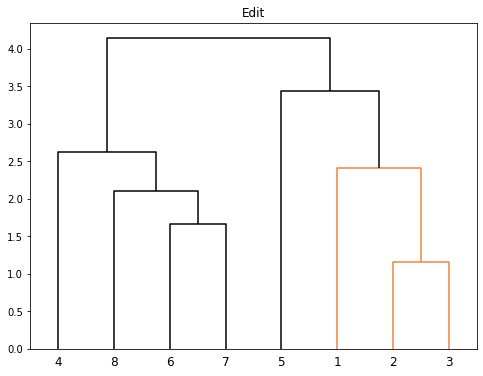

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Edit")

linkage_matrix = linkage(result_edit , "ward")
hierarchy.set_link_color_palette(['#000000', '#EE853A', '#6151E6'])
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),
                   color_threshold=3, above_threshold_color='black')

fig.savefig("edit_dendo.pdf")

plt.show()

#edit_matrix = squareform(np.array(result_edit))
#edit_csv = np.savetxt("edit_dist.csv", edit_matrix)

## CED results

In [ ]:
pool = mp.Pool(mp.cpu_count())
result_ced = pool.starmap(ced, [(seq_example[i], seq_example[j]) for i in range(nb_sequences) for j in range(i + 1, nb_sequences)])
pool.close()

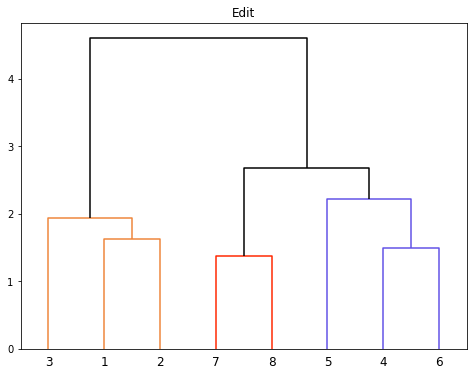

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.title(label = "Edit")

linkage_matrix = linkage(result_ced , "ward")
hierarchy.set_link_color_palette(['#EE853A', '#FF2600', '#6151E6'])
dendo = dendrogram(linkage_matrix, labels=range(1, nb_sequences + 1),
                   color_threshold=2.3, above_threshold_color='black')

fig.savefig("ced_dendo.pdf")

plt.show()

#edit_matrix = squareform(np.array(result_edit))
#edit_csv = np.savetxt("edit_dist.csv", edit_matrix)